# 03 Training a model

This part will look pretty generic- the only really `snorkel`-specific thing is that we'll randomly sample labels during training using the probabilistic labels from the last notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import tensorflow as tf

%matplotlib inline
from IPython.core.pylabtools import figsize

Load our preprocessed text:

In [3]:
df = pd.read_csv("groupname_preprocessed_full.csv")
len(df)

844782

In [4]:
df.head()

,end,eventid,label,labeled_sentence,name,sentence,start,type
0,35,197001010002,0,1/1/1970: Unknown ENTSTART African American E...,african american,1/1/1970: Unknown African American assailants...,19,NORP
1,100,197001010002,0,1/1/1970: Unknown African American assailants...,cairo,1/1/1970: Unknown African American assailants...,95,GPE
2,110,197001010002,0,1/1/1970: Unknown African American assailants...,illinois,1/1/1970: Unknown African American assailants...,102,GPE
3,125,197001010002,0,1/1/1970: Unknown African American assailants...,united states,1/1/1970: Unknown African American assailants...,112,GPE
4,39,197001010002,0,"There were no casualties, however, ENTSTART o...",one,"There were no casualties, however, one bullet...",36,CARDINAL


And our probalistic labels:

In [5]:
pos_probs = np.fromfile("pos_probs.numpy")
pos_probs.shape

(844782,)

Let's divide these into training and validation sets. 

* For train, use probabilistic labels
* For test, use actual ground truth since we have it
* I'm discarding any training points set to 0.5

In [6]:
indices = np.arange(pos_probs.size)
train_indices = indices % 10 != 0
test_indices = indices % 10 == 0

In [22]:
train_strings = df.labeled_sentence.values[train_indices]
train_probs = pos_probs[train_indices]

train_strings = train_strings[train_probs != 0.5]
train_probs = train_probs[train_probs != 0.5]

test_strings = df.labeled_sentence.values[test_indices]
# for test let's use the actual ground truth
test_labels = df.label.values[test_indices]

In [23]:
len(train_strings)

549477

## Build input pipelines

The only non-standard thing is the training generator- every time it's called, it randomly chooses a value for the label (0 or 1) using the `snorkel` label as a Bernoulli probability.

In [24]:
vocab_size=15000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, lower=True, oov_token=0)

In [25]:
tokenizer.fit_on_texts(train_strings)

In [26]:
train_strings[0]

' 1/1/1970: Unknown African American assailants fired several bullets at police headquarters in ENTSTART Cairo ENTEND , Illinois, United States '

In [27]:
train_x = tokenizer.texts_to_sequences(train_strings)
test_x = tokenizer.texts_to_sequences(test_strings)

In [28]:
train_x[0]

[400,
 400,
 752,
 67,
 355,
 713,
 10,
 84,
 301,
 2703,
 13,
 27,
 336,
 4,
 2,
 776,
 3,
 1806,
 133,
 215]

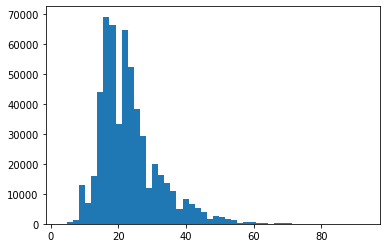

In [29]:
_ = plt.hist([len(x) for x in train_x], bins=50);

In [30]:
batch_size = 512
steps_per_epoch = int(len(pos_probs)/batch_size)

def _train_generator():
    while True:
        for i in range(len(train_x)):
            x = np.array(train_x[i], dtype=np.int64)
            y = np.random.binomial(1, train_probs[i])
            yield x,y
            
train_ds = tf.data.Dataset.from_generator(_train_generator, 
                                         (tf.int64, tf.int64),
                                         ((None), ()))
train_ds = train_ds.shuffle(50000)
train_ds = train_ds.padded_batch(batch_size,
                                padded_shapes=([None], []))
train_ds = train_ds.prefetch(1)

In [31]:
test_steps = int(len(test_labels)/batch_size)

In [32]:
def _test_generator():
    for i in range(len(test_x)):
        yield np.array(test_x[i], dtype=np.int64), test_labels[i]
        
test_ds = tf.data.Dataset.from_generator(_test_generator, 
                                         (tf.int64, tf.int64),
                                         ((None), ()))
test_ds = test_ds.padded_batch(batch_size,
                                padded_shapes=([None], []))
test_ds = test_ds.prefetch(1)

In [33]:
train_ds

<DatasetV1Adapter shapes: ((?, ?), (?,)), types: (tf.int64, tf.int64)>

In [34]:
it = train_ds.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    foo = sess.run(it)
    
print("x:", foo[0].shape)
print("y:", foo[1].shape)

x: (512, 67)
y: (512,)


# Build a model

In [35]:
inpt = tf.keras.layers.Input([None])
rnn_dim = 64

embed_layer = tf.keras.layers.Embedding(vocab_size, 25)
embedded = embed_layer(inpt)

lstm = tf.keras.layers.LSTM(rnn_dim, return_sequences=True)
bidir = tf.keras.layers.Bidirectional(lstm)
rnn_out = bidir(embedded)
rnn_out

<tf.Tensor 'bidirectional_1/concat:0' shape=(?, ?, 128) dtype=float32>

In [36]:
attention_inpt = tf.keras.layers.Input((None, rnn_dim*2))
# compute a weight for the vector at each step
attention_logits = tf.keras.layers.Dense(1)(attention_inpt)
# swap so STEPS are last instead of CHANNELS
attention_swapped = tf.keras.layers.Lambda(
    lambda x: tf.transpose(x, [0,2,1]), name="swap_axes")(attention_logits)
# use softmax to normalize
attention_normed = tf.keras.layers.Activation(
    tf.keras.activations.softmax, name="softmax_normalize")(attention_swapped)
# swap axes back to channels-last
attention_swapped_back = tf.keras.layers.Lambda(
    lambda x: tf.transpose(x, [0,2,1]), name="swapped_back")(attention_normed)
# multiply attention weights with output vectors
attention_weighted_rnn_outs = tf.keras.layers.Multiply(
    name="scaled_rnn_outs")([attention_inpt, attention_swapped_back])
# sum to reduce the tensor rank by 1; now we have a single vector that's 
# a weighted sum of RNN outputs
attention_out = tf.keras.layers.Lambda(
    lambda x: tf.reduce_sum(x, axis=1), name="rnn_weighted_sum")(attention_weighted_rnn_outs)
# also save weights so we can inspect later
attention_weights = tf.keras.layers.Lambda(
    lambda x: tf.reduce_sum(x, axis=2), name="attention_weights")(attention_swapped_back)

attention_model = tf.keras.Model(attention_inpt,
                                [attention_out, attention_weights],
                                name="attention_mechanism")

In [37]:
attention_result, weights = attention_model(rnn_out)
dense = tf.keras.layers.Dense(256, 
                              activation=tf.keras.activations.relu)(attention_result)
dropout = tf.keras.layers.Dropout(0.5)(dense)
dense2 = tf.keras.layers.Dense(256, 
                              activation=tf.keras.activations.relu)(dropout)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid,
                              name="output")(dropout2)

model = tf.keras.Model(inpt, [output, weights])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 25)          375000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         46080     
_________________________________________________________________
attention_mechanism (Model)  [(None, 128), (None, None 129       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
__________

In [39]:
model.outputs

[<tf.Tensor 'output/Sigmoid:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'attention_mechanism/attention_weights/Sum:0' shape=(?, ?) dtype=float32>]

In [40]:
model.compile(tf.keras.optimizers.RMSprop(1e-3),
             loss={"output":tf.keras.losses.binary_crossentropy},
             metrics=["accuracy"])

In [41]:
model.fit(train_ds, batch_size=batch_size,
         epochs=1, steps_per_epoch=steps_per_epoch,
         validation_data=test_ds, validation_steps=test_steps)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
1649/1649 [==============================] - 410s 249ms/step - loss: 0.4899 - output_loss: 0.4899 - output_acc: 0.8024 - val_loss: 0.4247 - val_output_loss: 0.4247 - val_output_acc: 0.8171
